In [1]:
###############################################################
# ASB-25623 Notebook to display Telescope/Instrument footprints on sky viewer
#
# ASB-25623     Brian McLean    Initial prototype v0.1 2024-02-29
###############################################################
import matplotlib.pyplot as plt
import numpy as np
import pysiaf
from selectSIAF import defineApertures, getVertices, computeStcsFootprint
from ipyaladin import Aladin

In [2]:
print('  HST PRD version = {}'.format(pysiaf.HST_PRD_VERSION))
print(' JWST PRD version = {}'.format(pysiaf.JWST_PRD_VERSION))
print('ROMAN PRD version = not implemented')

  HST PRD version = Latest
 JWST PRD version = PRDOPSSOC-065
ROMAN PRD version = not implemented


In [9]:
# define telescope pointing at target

selectedTelescope = 'roman'
selectedInstrument = 'ALL'      #Allowed options ALL, WFI, CGI
selectedAperture = 'ALL'        #Allowed options ALL or individual apertures listed in instrument documentation

#selectedTelescope = 'hst'
#selectedInstrument = 'ALL'     #Allowed options ALL, ACS, COS, FGS, NICMOS, STIS, WFC3
#selectedAperture = 'ALL'       #Allowed options ALL or individual apertures listed in instrument documentation

#selectedTelescope = 'jwst'
#selectedInstrument = 'ALL'     # Allow options ALL, FGS, MIRI, NIRCAM, NIRSPEC, NIRISS
#selectedAperture = 'ALL'       #Allowed options ALL or individual apertures listed in instrument documentation

# M101 
targetRa = 210.80243
targetDec = 54.34875
telescopePositionAngle = 180.0

In [10]:
# Set up telescope/instrument/apertures

apertureList, V2Ref, V3Ref = defineApertures(selectedTelescope, selectedInstrument, selectedAperture)

# Set telescope pointing matrix
attmat = pysiaf.utils.rotations.attitude_matrix(V2Ref, V3Ref, targetRa, targetDec, telescopePositionAngle)

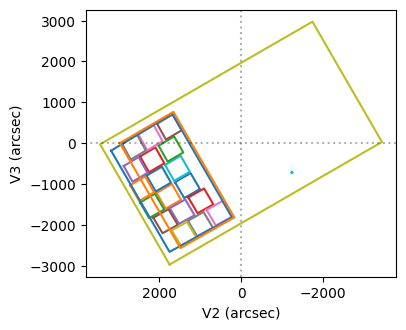

In [11]:
# OPTIONAL : set up plot of apertures (only works for QUAD, RECT, PICK aperture shapes)

plt.figure(figsize=(4, 4), facecolor='w', edgecolor='k')
ax = plt.gca()
for i in range(len(apertureList)):
    apertureSiaf = apertureList[i]
    # Skip circles which do not plot correctly
    if apertureSiaf.AperShape != 'CIRC':
        apertureSiaf.plot()

ax.set_aspect('equal')
# Add guide lines for boresight (V2, V3) = (0, 0)
ylim = ax.get_ylim()
xlim = ax.get_xlim()
ax.plot([0, 0], ylim, color='black', linestyle=':', alpha=0.3)
ax.plot(xlim, [0, 0], color='black', linestyle=':', alpha=0.3)
# Set the axis limits and invert the X-axis such that V2 is
# positive to the left
ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.invert_xaxis()
plt.show() 

In [12]:
# Loop through aperture list  (only works for QUAD, RECT, CIRC aperture shapes)
# Transform to sky coordinates, build footprints for passing to Aladin

combinedSregion=''
for i in range(len(apertureList)):
    apertureSiaf = apertureList[i]
    apertureSiaf.set_attitude_matrix(attmat)
    xVertices, yVertices = getVertices(apertureSiaf)
    
    # Skip PICK which do not have vertices
    if (xVertices is not None and yVertices is not None):
        skyRa, skyDec = apertureSiaf.idl_to_sky(xVertices, yVertices)
        apertureSregion = computeStcsFootprint(apertureSiaf, skyRa, skyDec)
        combinedSregion+=apertureSregion
        
print('\n'+combinedSregion)


POLYGON ICRS 210.02676105 54.61174092 210.21162143 54.55132911 210.31908982 54.66044444 210.13348326 54.72038875 POLYGON ICRS 209.80848562 54.68299394 209.98998869 54.62423288 210.09653109 54.73276444 209.91410644 54.79089472 POLYGON ICRS 209.61305709 54.74627935 209.79067313 54.68925701 209.89621275 54.79708284 209.71752589 54.85332630 POLYGON ICRS 210.18193015 54.71666932 210.36805263 54.65646339 210.47658631 54.76468944 210.29003740 54.82438387 POLYGON ICRS 209.96264808 54.78843911 210.14579103 54.73002135 210.25379428 54.83760343 210.07002794 54.89534726 POLYGON ICRS 209.76711903 54.85178569 209.94669129 54.79522383 210.05402199 54.90204605 209.87365062 54.95780352 POLYGON ICRS 210.39600174 54.80237319 210.58344293 54.74196524 210.69234185 54.84892509 210.50484059 54.90882909 POLYGON ICRS 210.17513321 54.87505294 210.36026570 54.81648695 210.46909229 54.92279369 210.28369733 54.98069380 POLYGON ICRS 209.98167960 54.93923774 210.16386607 54.88256794 210.27241478 54.98810738 210.089

In [13]:
aladin = Aladin(height=600, fov=1.0, survey="P/DSS2/color", target=str(targetRa)+' '+str(targetDec))
aladin

Aladin(fov=1.0, height=600.0, options=['allow_full_zoomout', 'coo_frame', 'fov', 'full_screen', 'log', 'overla…

In [14]:
aladin.add_overlay_from_stcs(combinedSregion,{"color":"green"})